In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501 (3).xlsx


In [22]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [23]:
# 시간 데이터 변환
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])
df['Pump-End'] = pd.to_datetime(df['Pump-End'])

# 시간 단위 인덱스 설정 (시작 시간 기준)
df.set_index('Pump-Begin', inplace=True)

In [24]:
# PM2.5 질량농도와 금속농도 컬럼 지정
pm25_col = 'Conc(ug/m3)'
metal_cols = [col for col in df.columns if '(ng/m3)' in col]

In [25]:
df_clean = df.copy()

# 숫자형 변환 및 나머지 Nah 변환
df_clean[pm25_col] = pd.to_numeric(df_clean[pm25_col], errors='coerce')
for metal in metal_cols:
    df_clean[metal] = pd.to_numeric(df_clean[metal], errors='coerce')

# 음수값 Nah 처리
df_clean[pm25_col] = df_clean[pm25_col].apply(lambda x: x if x >= 0 else np.nan)
for metal in metal_cols:
    df_clean[metal] = df_clean[metal].apply(lambda x: x if x >= 0 else np.nan)

# 극단값 처리 (평균 ± 3표준편차)
for col in [pm25_col] + metal_cols:
    mean_val = df_clean[col].mean()
    std_val = df_clean[col].std()
    df_clean[col] = df_clean[col].apply(lambda x: x if (mean_val - 3*std_val <= x <= mean_val + 3*std_val) else np.nan)

df_clean.head()

,Pump-End,MassResetTime,Number-of-Split,Analysis-Id,Alarms,ElemError,Mass(ug),Conc(ug/m3),BP_Mass(ugC),BP_Conc(ugC/m3),...,Cd(ng/m3),In(ng/m3),Sn(ng/m3),Sb(ng/m3),Te(ng/m3),Cs(ng/m3),Ba(ng/m3),Ce(ng/m3),Pb(ng/m3),Bi(ng/m3)
Pump-Begin,,,,,,,,,,,,,,,,,,,,,
2025-01-10 10:53:43,2025-01-10 12:00:00,2025-01-10 12:00:00,0,NaN,0x0004000000000000,0x4000000000000000,-22.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-10 12:00:00,2025-01-10 13:00:00,2025-01-10 13:00:00,0,2917.0,0x0000000000000000,0x0000000000000000,-19.7,NaN,NaN,NaN,...,316.97,57.61,30.11,29.99,5.94,NaN,0.0,NaN,16.83,6.62
2025-01-10 13:00:00,2025-01-10 14:00:00,2025-01-10 14:00:00,0,2918.0,0x0000000000000000,0x0000000000000000,10.1,10.20,NaN,NaN,...,313.15,69.71,NaN,NaN,28.56,NaN,0.0,NaN,13.57,NaN
2025-01-10 14:00:01,2025-01-10 15:00:00,2025-01-10 15:00:00,0,2919.0,0x0000000000000000,0x0000000000000000,6.9,6.90,NaN,NaN,...,292.73,54.34,6.92,28.12,47.94,NaN,0.0,NaN,16.47,8.02
2025-01-10 15:00:00,2025-01-10 16:00:00,2025-01-10 16:00:00,0,2920.0,0x0000000000000000,0x0000000000000000,6.2,6.26,NaN,NaN,...,347.83,55.92,23.70,24.88,23.03,NaN,0.0,NaN,2.43,7.10


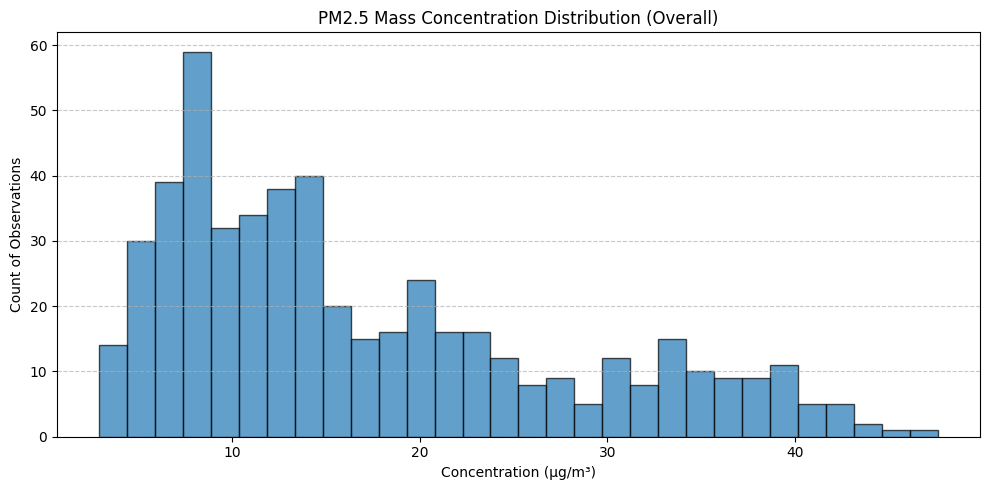

In [40]:
# 전체 히스토그램
pm25_data = df_clean[pm25_col].dropna()

plt.figure(figsize=(10,5))
plt.hist(pm25_data, bins=30, edgecolor='black', alpha=0.7)
plt.title('PM2.5 Mass Concentration Distribution (Overall)')
plt.xlabel('Concentration (µg/m³)')
plt.ylabel('Count of Observations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [30]:
# 시간 데이터 변환
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'], errors='coerce')

In [36]:
# Hour 컬럼 생성
df['Hour'] = df['Pump-Begin'].dt.hour

In [35]:
# PM2.5 컬럼 정의
pm25_col = 'Conc(ug/m3)'

In [37]:
# 숫자형 변환
df[pm25_col] = pd.to_numeric(df[pm25_col], errors='coerce')
for metal in metal_cols:
    df[metal] = pd.to_numeric(df[metal], errors='coerce')

# 음수값 제거
df[pm25_col] = df[pm25_col].apply(lambda x: x if x >= 0 else np.nan)
for metal in metal_cols:
    df[metal] = df[metal].apply(lambda x: x if x >= 0 else np.nan)

# 이상치 제거 (평균 ± 3표준편차)
for col in [pm25_col] + metal_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = df[col].apply(lambda x: x if (mean_val - 3*std_val <= x <= mean_val + 3*std_val) else np.nan)

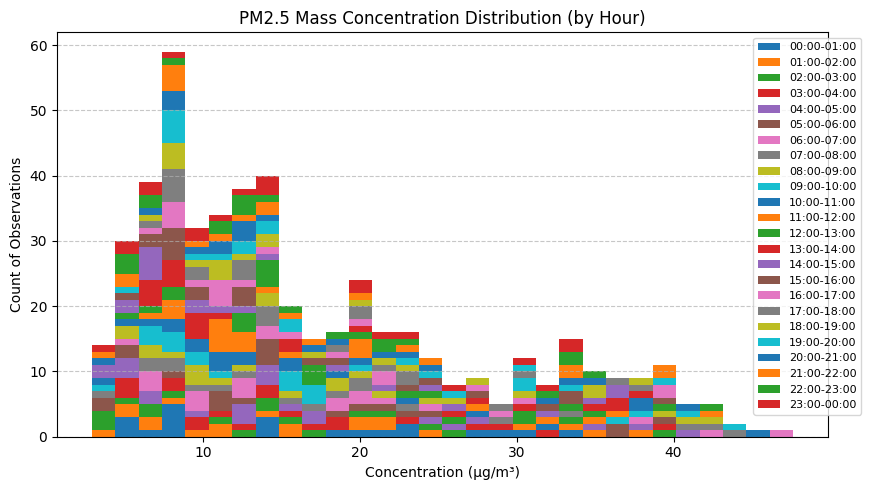

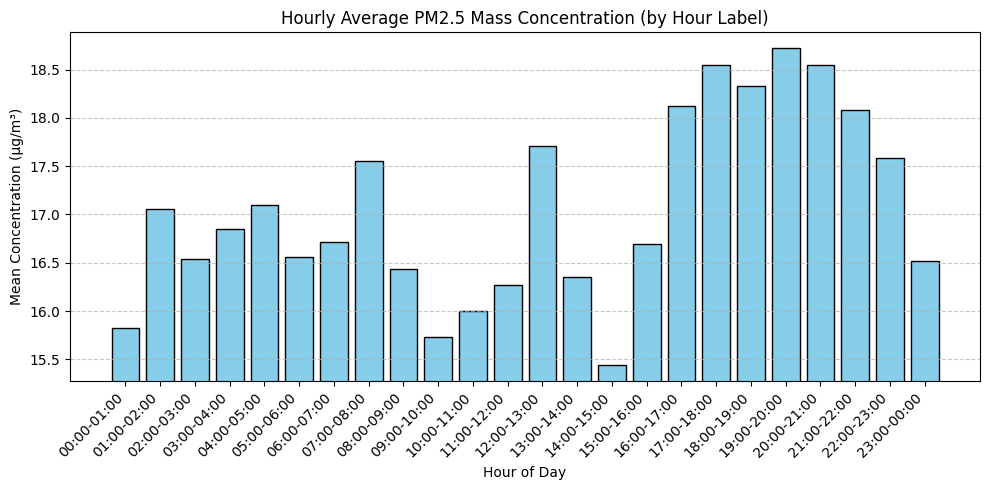

In [42]:
def plot_hourly_hist_and_avg(df, column_name, unit):
    # 시간 라벨 생성
    hour_labels = [f"{str(h).zfill(2)}:00-{str((h+1)%24).zfill(2)}:00" for h in range(24)]
    df['Hour_Label'] = df['Hour'].map({h: label for h, label in enumerate(hour_labels)})

    # 1. 시간대별 스택형 히스토그램
    plt.figure(figsize=(10,5))
    plt.hist([df[df['Hour'] == h][column_name].dropna() for h in range(24)],
        bins=30,
        stacked=True,
        label=hour_labels)
    plt.title(f'PM2.5 Mass Concentration Distribution (by Hour)')
    plt.xlabel(f'Concentration ({unit})')
    plt.ylabel('Count of Observations')
    plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 2. 시간대별 평균 막대그래프
    hourly_avg = df.groupby('Hour_Label')[column_name].mean()
    plt.figure(figsize=(10,5))
    plt.bar(hourly_avg.index, hourly_avg.values, color='skyblue', edgecolor='black')
    plt.title(f'Hourly Average PM2.5 Mass Concentration (by Hour Label)')
    plt.xlabel('Hour of Day')
    plt.ylabel(f'Mean Concentration ({unit})')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # y축 범위 확장
    ymin = hourly_avg.min() - (hourly_avg.max() - hourly_avg.min()) * 0.05
    ymax = hourly_avg.max() + (hourly_avg.max() - hourly_avg.min()) * 0.05
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.show()

# PM2.5 분석
plot_hourly_hist_and_avg(df, pm25_col, 'µg/m³')

In [ ]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [ ]:
# 시간 데이터 변환
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])
df['Pump-End'] = pd.to_datetime(df['Pump-End'])

# 시간 단위 인덱스 설정 (시작 시간 기준)
df.set_index('Pump-Begin', inplace=True)

In [ ]:
# PM2.5 컬럼 지정
pm25_col = 'Conc(ug/m3)'

In [ ]:
# 음수값, 극단값 제거
df[pm25_col] = pd.to_numeric(df[pm25_col], errors='coerce')
df[pm25_col] = df[pm25_col].apply(lambda x: x if x >= 0 else np.nan)

mean_val = df[pm25_col].mean()
std_val = df[pm25_col].std()
df[pm25_col] = df[pm25_col].apply(lambda x: x if (mean_val - 3*std_val <= x <= mean_val + 3*std_val) else np.nan)

In [ ]:
# 시간(hour) 컬럼 추가
df['Hour'] = df.index.hour

In [ ]:
# Hour 라벨을 "00:00-01:00" 형식으로 변환
hour_labels = [f"{str(h).zfill(2)}:00-{str(h+1).zfill(2)}:00" if h < 23 else "23:00-00:00" for h in range(24)]
df['Hour_Label'] = df['Hour'].map({h: label for h, label in enumerate(hour_labels)})

/tmp/ipython-input-893772777.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(hourly_avg.index, rotation=45, ha='right')


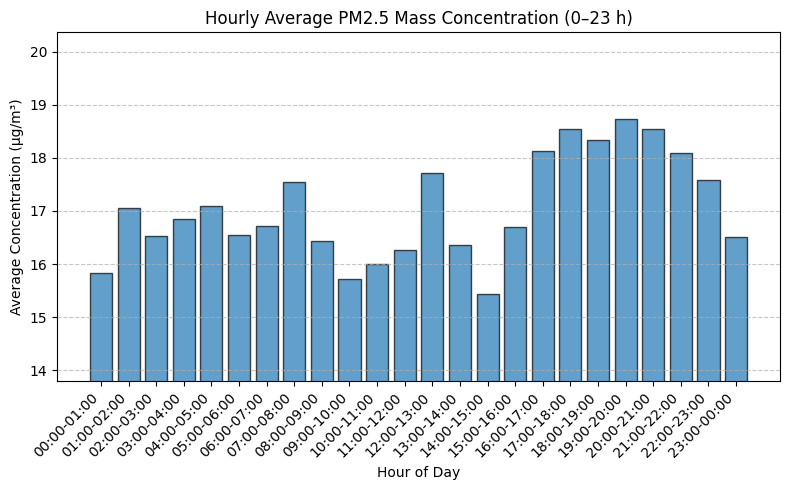

In [43]:
# 그래프 그리기
fig, ax = plt.subplots (figsize=(8, 5))

# 시간대별 평균
hourly_avg = df.groupby('Hour_Label')[pm25_col].mean()

# 그래프 기본설정
ax.bar(hourly_avg.index, hourly_avg.values, edgecolor='black', alpha=0.7)
ax.set_title('Hourly Average PM2.5 Mass Concentration (0–23 h)')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Concentration (µg/m³)')
ax.set_xticklabels(hourly_avg.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

#y축 범위 확장
y_min = hourly_avg.min() - (hourly_avg.max() - hourly_avg.min()) * 0.5
y_max = hourly_avg.max() + (hourly_avg.max() - hourly_avg.min()) * 0.5
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()